In [ ]:
# Liza Tatishev
# June 9, 2025

# Using Eckstein et al.'s (2022) "Reinforcement learning and Bayesian inference provide
# complementary models for the unique advantage of adolescents in stochastic reversal"
# publication and public data sets as a means of studying RL models.

In [2]:
# imports
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import spearmanr

In [3]:
# All RL models are implemented from the original
# RL model seen in class (RL(param, n) as in model_validation_solutions.ipynb).

# a basic RL model adapted from numerical_optimization_solutions.ipynb 
# to account for Eckstein et al.'s task design
# n is the number of trials, participants completed 120 trials 
# This is for one participant.
# Default number of blocks=7, unless otherwise specified.
# Default number of trials=120 unless otherwise specified.
def basic_RL(param, n=7, N=120):
    # model parameters
    beta = param[0] # decision temp
    alpha = param[1]    # learning rate

    # task parameters
    Data = np.ones(6)

    # initialize Q-values
    Q = np.array([.5, .5])
    Qs=np.empty((N,len(Q)))

    block = 0 # initialize block
    trial = 0 # intialize trials
    correct_box = np.random.choice([0, 1]) # correct box is 0 or 1

    # look over blocks
    for block in range(n):
        # set the correct box randomly at the begginning of the block
        correct_box = 1-correct_box
        
        # participants must reach a performance criterion of 7-15 rewards for a given block,
        # pre-randomized for each block, before the next switch occurs.
        # (any number of non-rewarded trials allowed in between rewarded trials)
        n_rewards = np.random.randint(7, 16) 
        r_count = 0     # count rewards for the block
        r = None        # is reward 0 or 1?

        switch_trial = False # switch trial?

        # loop over trials
        while trial < N:
            Qs[trial,:]=Q

            # compute softmax probabilities
            softmax = np.full(2, np.nan)
            softmax[1] = np.exp(beta * Q[1]) / (np.exp(beta * Q[1]) + np.exp(beta * Q[0]))
            softmax[0] = 1 - softmax[1]

            # pick action
            a = np.random.choice(range(2), p=softmax)

            # determine if action is correct
            Cor = a == correct_box

            # the first correct choice after a switch is always rewarded
            if switch_trial & Cor:
                r_count+=1
                r = 1
                switch_trial = False    # reset switch trial
            elif Cor:
                # the correct box is rewarded 75% of the itme
                r = np.random.choice([1, 0], p=[0.75, 0.25])
                if r == 1:
                    r_count+=1
            # else selected box was wrong and reward = 0
            else:
                r = 0

            # update Q value
            Q[a] += alpha * (r - Q[a])

            # store data
            Data = np.vstack((Data, np.array([a, r, correct_box, trial, switch_trial, block])))
            trial+=1
            
            # if the participant reaches the performance criterion and
            # the trial was rewarded, switch and enter a new block
            if r_count >= n_rewards and r == 1: 
                switch_trial = True
                block += 1
                break

        # check if reached max
        if trial > N:
            break
        
    return Data[1:], Qs  # remove first row

In [4]:
# a function to simulate and plot the agent for n number of participants
def sim(model, params, n_participants):
    all_Data = []
    all_Qs = []

    for p in range(n_participants):
        # switches define the number of blocks, there are 5-9 total switches.
        # after each switch, participant enters a new block.
        nblocks = np.random.randint(5, 10)
        Data = np.ones(6)
        Qs=np.empty((120,2))
        
        if model == "basic_RL_simulate":
            Data, Qs = basic_RL(params, nblocks)
        elif model == "four_param_RL":
            Data, Qs = four_param_RL(params, nblocks)
        else:
            return("Not a valid model")
        
        p_col = np.full((Data.shape[0], 1), p)
        all_Data.append(np.hstack((p_col, Data)))
        all_Qs.append(Qs)

    return np.vstack(all_Data), all_Qs

def plot_sim(Data, Qs, n_participants, fig_path):
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)

    for p in range(n_participants):
        p_Data = Data[Data[:, 0] == p]  # participant data
        p_Data = p_Data[np.argsort(p_Data[:, 4])]  # sort by trial number (col 4)
        n_trials =  p_Data.shape[0]
        p_Qs = Qs[p]

        correct_box = p_Data[:, 3]

        # get array of when block switch trials
        blocks = np.unique(p_Data[:, 6].astype(int))
        switch_trials = []
        prev_b = None
        for i, row in enumerate(p_Data):
            curr_b = int(row[6])
            if curr_b != prev_b:
                switch_trials.append(i)
                prev_b = curr_b

        plt.figure()
        plt.plot(np.arange(n_trials), correct_box, linestyle='-', markersize=3, color="green")
        plt.plot(p_Qs[:,0],label='Q[0]')
        plt.plot(p_Qs[:,1],label='Q[1]')
        plt.xlabel('Trial number')
        plt.ylabel('Correct box')
        plt.title(f'Participant {p} {len(blocks)} Blocks')
        for t in switch_trials:
            plt.axvline(x=t, color='red', linestyle='--', alpha=0.7)

        # plt.savefig(f'{fig_path}_{p}.png')


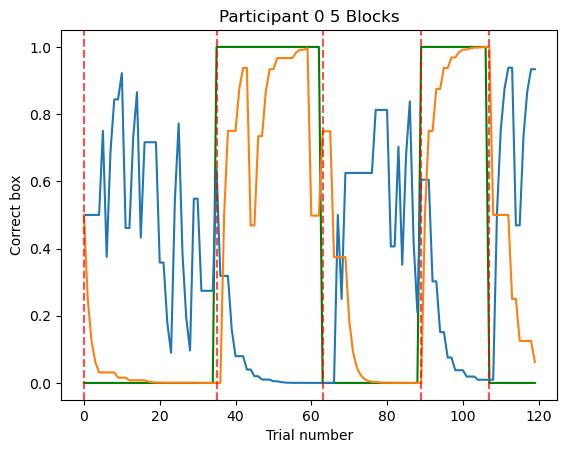

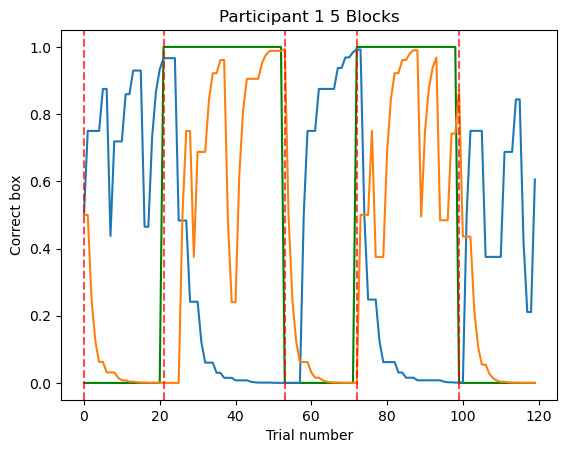

In [5]:
alpha=0.1
beta=0.5
params=[alpha, beta]

# # sanity check
# nblocks = np.random.randint(5, 10)
# Data, Qs = basic_RL(params, nblocks)
# print(Data.shape)
# print(Qs)

n_participants=2
sim_Data, sim_Qs = sim("basic_RL_simulate", params, n_participants)
plot_sim(sim_Data, sim_Qs, n_participants, 'figures/basic_RL_simulate')

In [6]:
# adapted from numerical_optimization_solutions.ipynb
def basic_LLH(param, Data):
    # model parameters
    beta = param[0]
    alpha = param[1]

    # task parameters
    n = len(np.unique(Data[:, 5]))  # number of blocks
    llh = 0

    # loop over blocks
    for b in range(n):
        
        # initialize Q-values
        Q = np.array([0.5, 0.5])

        # get block data
        b_data = Data[Data[:, 5] == b]
        b_data = b_data[np.argsort(b_data[:, 3])] # sort by trial number

        # there are as many trials as there are rows
        for row in b_data:
            # extract choice and reward
            a = int(row[0])      
            r = row[1]          

            # compute softmax probabilities
            softmax = np.full(2, np.nan)
            softmax[1] = 1 / sum(np.exp(beta * (Q - Q[1])))
            softmax[0] = 1 - softmax[1]

            # update Q-values
            Q[a] += alpha * (r - Q[a])

            # update llh
            llh += np.log(softmax[a])

    return -llh

In [7]:
# alpha=1.0
# beta=0.5
# params=[alpha, beta]
# nblocks = np.random.randint(5, 10)
# Data, Qs = basic_RL(params, nblocks)
# print(basic_LLH([5, 0.1], Data))
# print(basic_LLH([5, 0.5], Data))

In [8]:
# the basic_RL implemented with the four params described in Eckstein et al.
def four_param_RL(param, n=7, N=120):
    beta = param[0]
    # split learning rate into positive and negative
    alpha_pos = param[1]
    alpha_neg = param[2]
    persistence = param[3] # choice persistence parameter ('stickiness')
    
    # task parameters
    Data = np.ones(6)

    # initialize Q-values
    Q = np.array([.5, .5])
    Qs=np.empty((N,len(Q)))

    block = 0 # initialize blocks 
    trial = 0 # initialize trials
    prev_a = None # store previous action
    # loop over blocks
    for block in range(n):
        correct_box = np.random.choice([0, 1]) # correct box is 0 or 1
        n_rewards = np.random.randint(7, 16) # performance criterion
        r_count = 0     # count rewards for the block
        r = None        # is reward 0 or 1?

        switch_trial = False # switch trial?

        # loop over trials
        while trial < N:    
            Qs[trial,:]=Q

            # compute softmax probabilities
            if prev_a is not None:
                Q_pers_1 = Q[1]+prev_a*persistence
                Q_pers_0 = Q[0]+(1-prev_a)*persistence
                softmax[1] = np.exp(beta * (Q_pers_1) ) / (np.exp(beta * Q_pers_1) + np.exp(beta * Q_pers_0))
                softmax[0] = 1 - softmax[1]
            else: 
                softmax = np.full(2, np.nan)
                softmax[1] = np.exp(beta * Q[1]) / (np.exp(beta * Q[1]) + np.exp(beta * Q[0]))
                softmax[0] = 1 - softmax[1]
                
            # pick action
            a = np.random.choice(range(2), p=softmax)

            # determine if action is correct
            Cor = a == correct_box

            # the first correct choice after a switch is always rewarded
            if switch_trial & Cor:
                r_count+=1
                r = 1
                switch_trial = False
            elif Cor:
                # the correct box is rewarded 75% of the itme
                r = np.random.choice([1, 0], p=[0.75, 0.25])
                if r == 1:
                    r_count+=1
            # else selected box was wrong and reward = 0
            else:
                r = 0

            # update Q values
            # splitting learning rates allows to differentiate rewarded vs. 
            # non-rewarded trials 
            if r == 1:
                Q[a] += alpha_pos * (r-Q[a])
            else:
                Q[a] += alpha_neg * (r-Q[a])
            
            # "counterfacutal" updates on unchosen actions
            if r == 1:
                Q[1-a] += alpha_pos * ((1-r)-Q[1-a])
            else:
                Q[1-a] += alpha_neg * ((1-r)-Q[1-a])

            # store data
            Data = np.vstack((Data, np.array([a, r, correct_box, trial, switch_trial, block])))
            prev_a = a
            trial+=1
            
            # check if participant reaches performance criterion
            if r_count >= n_rewards and r == 1: 
                switch_trial = True
                block += 1
                break
        
        # check if reached max
        if trial > N:
            break

    return Data[1:], Qs  # remove first row

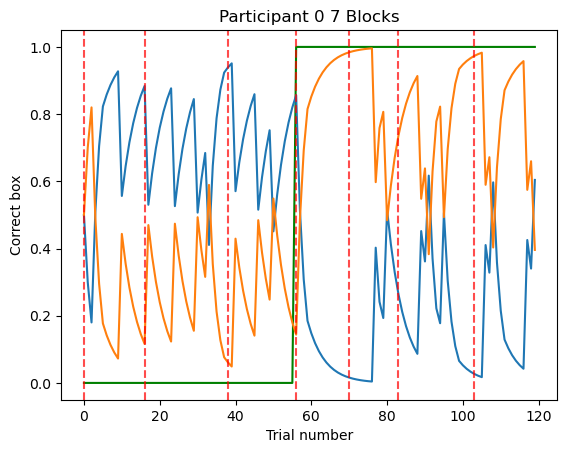

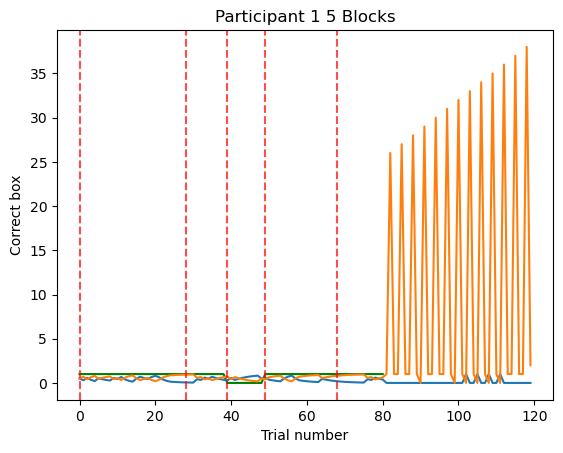

In [9]:
beta = 5
alphapos = 0.2
alphaneg = 0.4
p = 0.5 # between 0 and 1
params = [beta, alphapos, alphaneg, p]

# # sanity check
# nblocks = np.random.randint(5, 10)
# Data, Qs = four_param_RL(params, nblocks)
# print(Data)
# print(Qs)

n_participants=2
sim_fourparam_Data, sim_fourparam_Qs = sim("four_param_RL", params, n_participants)
plot_sim(sim_fourparam_Data, sim_fourparam_Qs, n_participants, 'figures/fourparam_RL_simulate')

In [10]:
def four_param_LLH(params, Data):    
    # set up parameters
    beta = params[0] # scaling?
    alpha_pos = params[1]
    alpha_neg = params[2]
    persistence = params[3]
    
    # task parameters
    n = int(len(np.unique(Data[:, 5].astype(int))))  # number of blocks
    llh = 0

    # loop over blocks
    for b in range(n):
        
        # initialize Q-values
        Q = np.array([0.5, 0.5])

        # get block data
        b_data = Data[Data[:, 5] == b]
        b_data = b_data[np.argsort(b_data[:, 3])] # sort by trial number

        prev_a = None
        # loop over rows
        for row in b_data:
            # extract choice and reward
            a = int(row[0])      
            r = row[1]          

            # compute softmax probabilities
            if prev_a is not None:
                Q_pers_1 = Q[1]+prev_a*persistence
                Q_pers_0 = Q[0]+(1-prev_a)*persistence
                softmax[1] = np.exp(beta * (Q_pers_1) ) / (np.exp(beta * Q_pers_1) + np.exp(beta * Q_pers_0))
                softmax[0] = 1 - softmax[1]
            else: 
                softmax = np.full(2, np.nan)
                softmax[1] = np.exp(beta * Q[1]) / (np.exp(beta * Q[1]) + np.exp(beta * Q[0]))
                softmax[0] = 1 - softmax[1]

            # update Q-values
            if r == 1:
                Q[a] += alpha_pos * (r-Q[a])
            else:
                Q[a] += alpha_neg * (r-Q[a])

            # counterfactual updating
            if r == 1:
                Q[1-a] += alpha_pos * ((1-r)-Q[1-a])
            else:
                Q[1-a] += alpha_neg * ((1-r)-Q[1-a])

            # update llh
            llh += np.log(softmax[a])
            prev_a = a

    return -llh

## Parameter Recovery

In [11]:
# from model_validation_solutions.ipynb
def optimize(fname,
             bounds,
             Data,
             niter,
             toplot=False,
            ):

    #  bestparameters,bestllh = optimize(fname,bounds, Data,niter,toplot) runs
    #  the minimize function niter times on the function fname, with constraints
    #  bounds to find parameters that best fit the data Data. It returns the
    #  best likelihood and best fit parameters over the niter iterations.

    #  ## fname is the python function to optimize. fname
    #  should take as first argument a 1 by n vector of parameters.
    #  Note the bounds are set up differently than they are in Matlab,
    #  And should come as a list of [min,max] pairs. (ie. [[min,max],[min,max], ...])
    #
    #  ## Data is the data set to be fit by likelihood function fname.
    #  ## niter is the number of starting points for the optimization
    #  ## toplot is an optional argument; if plot~=0, this function will plot the
    #  best likelihood as a function of starting point iterations.

    #  ## best parameters is the 1*n vector of parameters found to minimize the
    #  negative log likelihood over the data.
    #  bestllh is the log likelihood value for the best parameters.

    outcomes = np.full([niter, len(bounds)+1], np.nan)
    optimcurve = np.full(niter, np.nan)
    for i in range(niter):

        # random starting point based on maximum bounds
        params0 = np.array([bound[1] * np.random.rand() for bound in bounds])

        # compute the function value at the starting point
        llh0 = fname(params0, Data)

        # run the optimizer with constraints
        result = minimize(fun=fname, x0=params0, args=(Data), bounds=bounds)
        x = result.x
        bestllh = fname(x, Data)
        outcomes[i, :] = [bestllh] + [xi for xi in x]
        optimcurve[i] = min(outcomes[:(i+1), 0])

    # find the global minimum out of all outcomes
    i = np.argwhere(outcomes[:, 0] == np.min(outcomes[:, 0]))
    bestparameters = outcomes[i[0], 1:].flatten()
    bestllh = -outcomes[i[0], 0].flatten()[0]

    # plot the best llh found by the optimizer as a function of iteration number.
    if toplot:
        plt.figure()
        plt.plot(range(niter), np.round(optimcurve, 6), 'o-')
        plt.xlabel('iteration')
        plt.ylabel('best minimum')
        plt.title(str(nblocks) + ' blocks')

    return(bestparameters, bestllh)

### Basic 2 Parameter RL

In [12]:
# # from numerical_optimization_solutions.ipynb
# # sanity check
# # generate data
# beta = 5
# alpha = .1
# true_params = [beta, alpha]
# nblocks = np.random.randint(5, 10)
# basic_RL_Data, Qs = basic_RL(true_params, nblocks)

# # set up optimizer
# niter = 20
# betamin = 0
# betamax = 20
# alphamin = 0
# alphamax = 1
# bounds = [[betamin, betamax], [alphamin, alphamax]]

# # compute likelihood of the true parameters as a baseline
# basic_RL_nllh_trueparams = basic_LLH([beta, alpha], basic_RL_Data)
# basic_RL_llh_trueparams = -1 * basic_RL_nllh_trueparams
# basic_RL_bestparameters, basic_RL_bestllh = optimize(basic_LLH, bounds, basic_RL_Data, niter, toplot=True)

# print('loglikelihood for true params is {0}, best loglikelihood is {1}'.format(basic_RL_nllh_trueparams, basic_RL_bestllh))
# print('true beta is {0}, recovered beta is {1}'.format(beta, basic_RL_bestparameters[0]))
# print('true alpha is {0}, recovered alpha is {1}'.format(alpha, basic_RL_bestparameters[1]))

In [13]:
# generate and recover, from numerical_optimization.ipynb
n_participants = 200
true_betas = []
recovered_betas = []
true_alphas = []
recovered_alphas = []

for p in range(n_participants):
    # generate data
    beta = np.random.uniform(1, 10)
    alpha = np.random.uniform(0, 1)
    true_params = [beta, alpha]
    nblocks = np.random.randint(5, 10)
    basic_RL_Data, Qs = basic_RL(true_params, nblocks)

    # set up optimizer
    niter = 20
    betamin = 0
    betamax = 10
    alphamin = 0
    alphamax = 1
    bounds = [[betamin, betamax], [alphamin, alphamax]]
    basic_RL_bestparameters, basic_RL_bestllh = optimize(basic_LLH, bounds, basic_RL_Data, niter, toplot=False)

    # save true and recovered parameters
    true_betas.append(beta)
    recovered_betas.append(basic_RL_bestparameters[0])
    true_alphas.append(alpha)
    recovered_alphas.append(basic_RL_bestparameters[1])

true_betas = np.array(true_betas)
recovered_betas = np.array(recovered_betas)
true_alphas = np.array(true_alphas)
recovered_alphas = np.array(recovered_alphas)

Text(0.5, 1.0, 'Recovered alpha vs. beta, correlation: 0.021, p-value: 0.769')

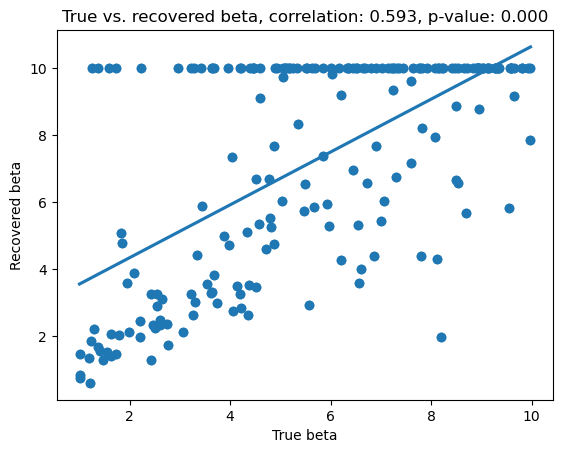

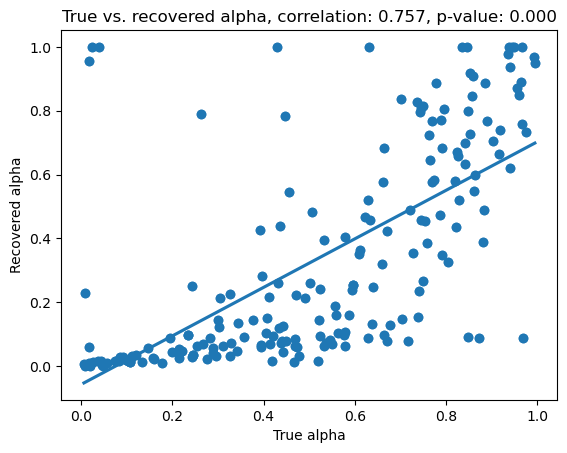

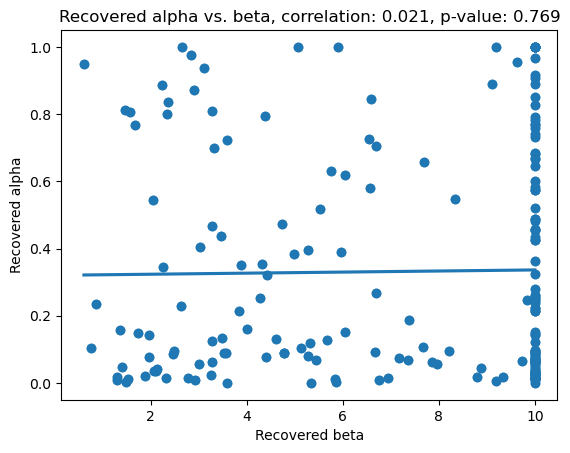

In [36]:
# get Spearman correlations
corr_b, pval_b = spearmanr(true_betas, recovered_betas)
corr_a, pval_a = spearmanr(true_alphas, recovered_alphas)
corr_ab, pval_ab = spearmanr(recovered_betas, recovered_alphas)


# plotting
# beta
plt.figure()
plt.scatter(true_betas, recovered_betas)
sns.regplot(x=true_betas, y=recovered_betas, ci=None)
plt.xlabel('True beta')
plt.ylabel('Recovered beta')
plt.title(f"True vs. recovered beta, correlation: {corr_b:.3f}, p-value: {pval_b:.3f}")
# plt.savefig('figures/basic_recovery_beta.png')


# alpha-
plt.figure()
plt.scatter(true_alphas, recovered_alphas)
sns.regplot(x=true_alphas, y=recovered_alphas, ci=None)
plt.xlabel('True alpha')
plt.ylabel('Recovered alpha')
plt.title(f"True vs. recovered alpha, correlation: {corr_a:.3f}, p-value: {pval_a:.3f}")
# plt.savefig('figures/basic_recovery_alpha.png')

# alpha vs. beta
plt.figure()
plt.scatter(recovered_betas, recovered_alphas)
sns.regplot(x=recovered_betas, y=recovered_alphas, ci=None)
plt.xlabel('Recovered beta')
plt.ylabel('Recovered alpha')
plt.title(f"Recovered alpha vs. beta, correlation: {corr_ab:.3f}, p-value: {pval_ab:.3f}")
# plt.savefig('figures/basic_recovery_alpha_vs_beta.png')

# "a small B induced decision noise (increasing exploratory choices, 
# and a large B allowed for reward-maximizing choices" 


### Four Parameter RL

In [15]:
# # sanity check
# # For four parameter RL model
# beta = 5
# alphapos = 0.2
# alphaneg = 0.4
# p = 0.5 # should be between 0 and 1
# true_params = [beta, alphapos, alphaneg, p]
# nblocks = np.random.randint(5, 10)
# fourRL_Data, Qs = four_param_RL(true_params, nblocks)

# # betamin/max and alphamin/max defined earlier
# pmin = 0
# pmax = 1
# # set up the optimizer
# bounds_fourRL = [[betamin, betamax], [alphamin, alphamax], [alphamin, alphamax], [pmin, pmax]]

# fourRL_nllh_trueparams = four_param_LLH([beta, alphapos, alphaneg, p], fourRL_Data)
# fourRL_llh_trueparams = -1 * fourRL_nllh_trueparams
# fourRL_bestparameters, fourRL_bestllh = optimize(four_param_LLH, bounds_fourRL, fourRL_Data, 20, toplot=True)

# print('loglikelihood for true params is {0}, best loglikelihood is {1}'.format(fourRL_nllh_trueparams, fourRL_bestllh))
# print('true beta is {0}, recovered beta is {1}'.format(beta, fourRL_bestparameters[0]))
# print('true alpha_pos is {0}, recovered alpha_pos is {1}'.format(alphapos, fourRL_bestparameters[1]))
# print('true alpha_neg is {0}, recovered alpha_neg is {1}'.format(alphaneg, fourRL_bestparameters[2]))
# print('true p is {0}, recovered p is {1}'.format(p, fourRL_bestparameters[3]))

In [16]:
n_participants = 200
true_betas = []
recovered_betas = []
true_alphapos = []
recovered_alphapos = []
true_alphaneg = []
recovered_alphaneg = []
true_p = []
recovered_p = []

for i in range(n_participants):
    # generate Data
    beta = np.random.uniform(1, 10)
    alphapos = np.random.uniform(0, 1)
    alphaneg = np.random.uniform(0, 1)
    p = np.random.uniform(0,1)
    true_params = [beta, alphapos, alphaneg, p]
    nblocks = np.random.randint(5, 10)
    four_param_Data, Qs = four_param_RL(true_params, nblocks)

    # set up optimizer
    niter = 20
    betamin = 0
    betamax = 10
    alphamin = 0
    alphamax = 1
    pmin = 0
    pmax = 1
    bounds = [[betamin, betamax], [alphamin, alphamax], [alphamin, alphamax], [pmin, pmax]]
    fourRL_bestparameters, fourRL_bestllh = optimize(four_param_LLH, bounds, four_param_Data, niter, toplot=False)

    # append
    true_betas.append(beta)
    recovered_betas.append(fourRL_bestparameters[0])
    true_alphapos.append(alphapos)
    recovered_alphapos.append(fourRL_bestparameters[1])
    true_alphaneg.append(alphaneg)
    recovered_alphaneg.append(fourRL_bestparameters[2])
    true_p.append(p)
    recovered_p.append(fourRL_bestparameters[3])

true_betas = np.array(true_betas)
recovered_betas = np.array(recovered_betas)
true_alphapos = np.array(true_alphapos)
recovered_alphapos = np.array(recovered_alphapos)
true_alphaneg = np.array(true_alphaneg)
recovered_alphaneg = np.array(recovered_alphaneg)
true_p = np.array(true_p)
recovered_p = np.array(recovered_p)

spearman corr for beta vs. alphapos: 0.184, p-value: 0.00901
spearman corr for beta vs. alphaneg: -0.075, p-value: 0.288
spearman corr for p vs. alphapos: -0.048, p-value: 0.504
spearman corr for p vs. alphaneg: 0.187, p-value: 0.00809


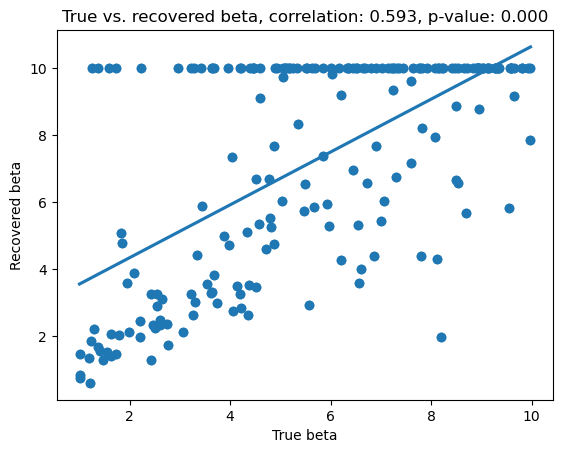

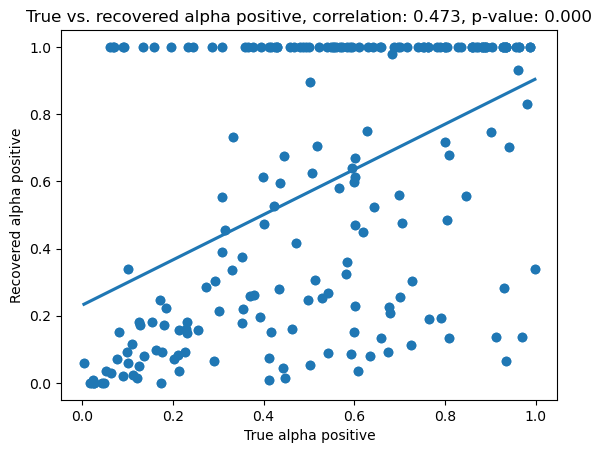

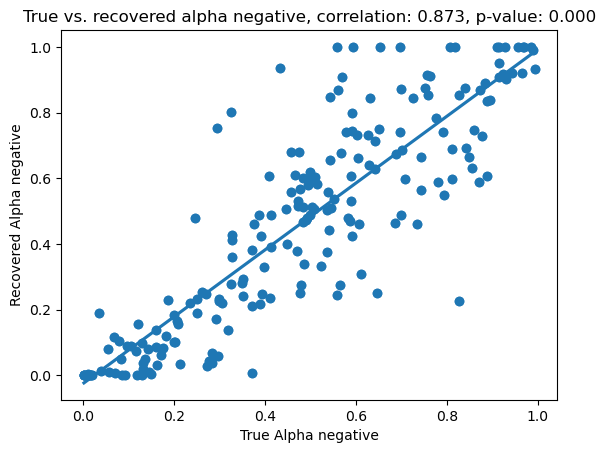

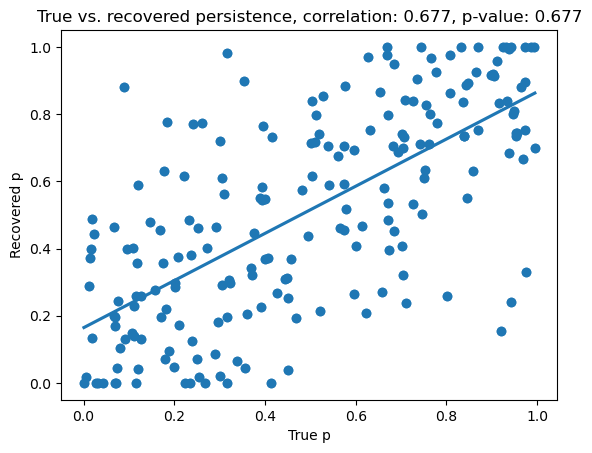

In [17]:
# get Spearman correlations
corr_b, pval_b = spearmanr(true_betas, recovered_betas)
corr_ap, pval_ap = spearmanr(true_alphapos, recovered_alphapos)
corr_an, pval_an = spearmanr(true_alphaneg, recovered_alphaneg)
corr_p, pval_p = spearmanr(true_p, recovered_p)

# plotting
# beta
plt.figure()
plt.scatter(true_betas, recovered_betas)
sns.regplot(x=true_betas, y=recovered_betas, ci=None)
plt.xlabel('True beta')
plt.ylabel('Recovered beta')
plt.title(f"True vs. recovered beta, correlation: {corr_b:.3f}, p-value: {pval_b:.3f}")
# plt.savefig('figures/fourparam_recovery_beta.png')

# alpha positive
plt.figure()
plt.scatter(true_alphapos, recovered_alphapos)
sns.regplot(x=true_alphapos, y=recovered_alphapos, ci=None)
plt.xlabel('True alpha positive')
plt.ylabel('Recovered alpha positive')
plt.title(f"True vs. recovered alpha positive, correlation: {corr_ap:.3f}, p-value: {pval_ap:.3f}")
# plt.savefig('figures/fourparam_recovery_alphapos.png')

# alpha negative
plt.figure()
plt.scatter(true_alphaneg, recovered_alphaneg)
sns.regplot(x=true_alphaneg, y=recovered_alphaneg, ci=None)
plt.xlabel('True Alpha negative')
plt.ylabel('Recovered Alpha negative')
plt.title(f"True vs. recovered alpha negative, correlation: {corr_an:.3f}, p-value: {pval_an:.3f}")
# plt.savefig('figures/fourparam_recovery_alphaneg.png')

# persistence
plt.figure()
plt.scatter(true_p, recovered_p)
sns.regplot(x=true_p, y=recovered_p, ci=None)
plt.xlabel('True p')
plt.ylabel('Recovered p')
plt.title(f"True vs. recovered persistence, correlation: {corr_p:.3f}, p-value: {corr_p:.3f}")
# plt.savefig('figures/fourparam_recovery_p.png')


# some more Spearman correlations
# "Parameters p and B controlled the translation of RL value into choices
# increasing persistence p increased the probability of repeating actions independently of action values"
corr_bap, pval_bap = spearmanr(recovered_betas, recovered_alphapos)
print(f"spearman corr for beta vs. alphapos: {corr_bap:.3f}, p-value: {pval_bap:.3g}")

corr_ban, pval_ban = spearmanr(recovered_betas, recovered_alphaneg)
print(f"spearman corr for beta vs. alphaneg: {corr_ban:.3f}, p-value: {pval_ban:.3g}")

corr_pap, pval_pap = spearmanr(recovered_p, recovered_alphapos)
print(f"spearman corr for p vs. alphapos: {corr_pap:.3f}, p-value: {pval_pap:.3g}")

corr_pan, pval_pan = spearmanr(recovered_p, recovered_alphaneg)
print(f"spearman corr for p vs. alphaneg: {corr_pan:.3f}, p-value: {pval_pan:.3g}")


## Model Recovery

Best fit 2 param RL model AIC= 168.9637304086362
Best fit 4 param RL model AIC= 78.55647690172478
random model AIC= 166.35532333438687


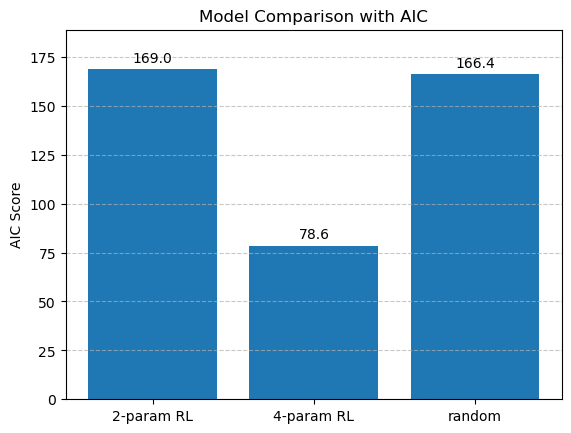

In [ ]:
# a simple AIC visualization
AIC_basic_RL = -2*basic_RL_bestllh + 2*2
AIC_fourRL = -2*fourRL_bestllh + 2*4

# # chance model likelihood
llh0 = 120 * np.log(.5)
AIC0 = -2*llh0 + 2*0 

print('Best fit 2 param RL model AIC=', str(AIC_basic_RL))
print('Best fit 4 param RL model AIC=', str(AIC_fourRL))
print('random model AIC=', str(AIC0))

# plotting
bars = plt.bar(['2-param RL', '4-param RL', 'random'], [AIC_basic_RL, AIC_fourRL, AIC0])
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{bar.get_height():.1f}', ha='center', va='bottom')

plt.ylabel('AIC Score')
plt.title('Model Comparison with AIC')
aic_values = [AIC_basic_RL, AIC_fourRL, AIC0]
plt.ylim(0, max(aic_values) + 20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.savefig('figures/model_recovery_1.png')

In [37]:
# from model_comparison_solutions.ipynb
n_participants = 200
# set up the optimizers
niter = 20
betamin = 0
betamax = 10
alphamin = 0
alphamax = 1
pmin = 0
pmax = 1
basic_bounds = [[betamin, betamax], [alphamin, alphamax]]
four_param_bounds = [[betamin, betamax], [alphamin, alphamax], [alphamin, alphamax], [pmin, pmax]]

# for storing results
AICs = np.empty((2, 2, n_participants))
BICs = np.empty((2, 2, n_participants))

for p in range(n_participants): 
    n_blocks = 7    # doesnt change for AIC/BIC calculations

    # generate data with both models
    beta = np.random.uniform(1, 10)
    alpha = np.random.uniform(0, 1)
    basic_trueparams = [beta, alpha]
    basic_Data, basic_Qs = basic_RL(basic_trueparams, nblocks)  # get data with basic RL

    # fit with two parameter model
    basic_bestparams, basic_bestllh = optimize(basic_LLH, basic_bounds, basic_Data, niter, toplot=False)
    four_param_bestparams, four_param_bestllh = optimize(four_param_LLH, four_param_bounds, basic_Data, niter, toplot=False)

    # compute AIC and BIC
    AIC_basic = -2*basic_bestllh + 2*2
    AIC_four = -2*four_param_bestllh + 2*4
    BIC_basic = -2*four_param_bestllh+np.log(basic_Data.shape[0])*2
    BIC_four = -2*four_param_bestllh+np.log(four_param_Data.shape[0])*4

    AICs[0, :, p] = [AIC_basic, AIC_four] - min(AIC_basic, AIC_four)
    BICs[0, :, p] = [AIC_basic, AIC_four] - min(AIC_basic,AIC_four)

    # fit with four parameter model
    beta = np.random.uniform(1, 10)
    alphapos = np.random.uniform(0, 1)
    alphaneg = np.random.uniform(0, 1)
    persistence = np.random.uniform(0,1)
    four_param_trueparams = [beta, alphapos, alphaneg, persistence]
    four_param_Data, four_param_Qs = four_param_RL(four_param_trueparams, nblocks)  # get data with four param RL

    basic_bestparams, basic_bestllh = optimize(basic_LLH, basic_bounds, four_param_Data, niter, toplot=False)
    four_param_bestparams, four_param_bestllh = optimize(four_param_LLH, four_param_bounds, four_param_Data, niter, toplot=False)

    AIC_basic = -2*basic_bestllh + 2*2
    AIC_four = -2*four_param_bestllh + 2*4
    BIC_basic = -2*four_param_bestllh+np.log(basic_Data.shape[0])*2
    BIC_four = -2*four_param_bestllh+np.log(four_param_Data.shape[0])*4

    # store the relative AICs/BICs
    AICs[1, :, p] = [AIC_basic, AIC_four] - min(AIC_basic, AIC_four)
    BICs[1, :, p] = [AIC_basic, AIC_four] - min(AIC_basic,AIC_four)

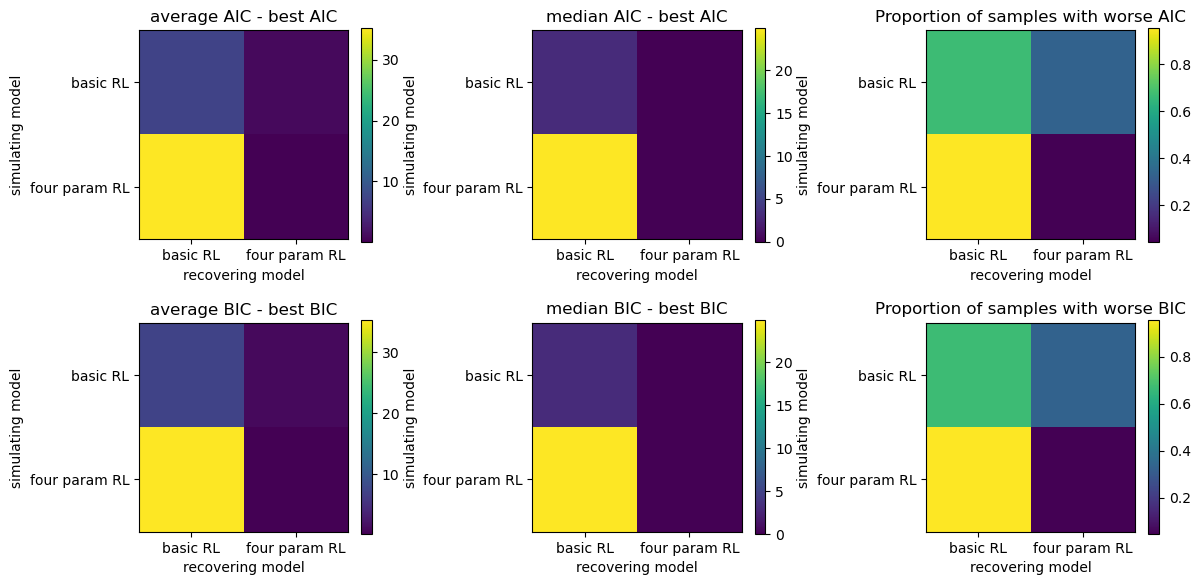

In [40]:
# visualize the results
# from model_comparison_solutions.ipynb
fig,axes = plt.subplots(2,3,figsize=(12,6))

## AIC
plt.sca(axes[0,0])
plt.imshow(np.mean(AICs,2))
plt.colorbar()
plt.xticks([0.0,1.0],['basic RL','four param RL'])
plt.yticks([0.0,1.0],['basic RL','four param RL'])
plt.xlabel('recovering model')
plt.ylabel('simulating model')
plt.title('average AIC - best AIC')

plt.sca(axes[0,1])
plt.imshow(np.median(AICs,2))
plt.colorbar()
plt.xticks([0.0,1.0],['basic RL','four param RL'])
plt.yticks([0.0,1.0],['basic RL','four param RL'])
plt.xlabel('recovering model')
plt.ylabel('simulating model')
plt.title('median AIC - best AIC')

plt.sca(axes[0,2])
plt.imshow(np.mean(AICs>0,2))
plt.colorbar()
plt.xticks([0.0,1.0],['basic RL','four param RL'])
plt.yticks([0.0,1.0],['basic RL','four param RL'])
plt.xlabel('recovering model')
plt.ylabel('simulating model')
plt.title('Proportion of samples with worse AIC')

## BIC
plt.sca(axes[1,0])
plt.imshow(np.mean(BICs,2))
plt.colorbar()
plt.xticks([0.0,1.0],['basic RL','four param RL'])
plt.yticks([0.0,1.0],['basic RL','four param RL'])
plt.xlabel('recovering model')
plt.ylabel('simulating model')
plt.title('average BIC - best BIC')

plt.sca(axes[1,1])
plt.imshow(np.median(BICs,2))
plt.colorbar()
plt.xticks([0.0,1.0],['basic RL','four param RL'])
plt.yticks([0.0,1.0],['basic RL','four param RL'])
plt.xlabel('recovering model')
plt.ylabel('simulating model')
plt.title('median BIC - best BIC')

plt.sca(axes[1,2])
plt.imshow(np.mean(BICs>0,2))
plt.colorbar()
plt.xticks([0.0,1.0],['basic RL','four param RL'])
plt.yticks([0.0,1.0],['basic RL','four param RL'])
plt.xlabel('recovering model')
plt.ylabel('simulating model')
plt.title('Proportion of samples with worse BIC')

plt.tight_layout()
plt.savefig('figures/model_recovery_2')

## Parameter fitting

In [21]:
# a function for .csv files
# the rl models expects data in the form [a, r, correct_box, trial, switch_trial, block]
def format_data_for_model(file):
    df = pd.read_csv(file)

    # participants completed a tutorial consisting of 36 trials 
    # # remove this data
    # df = df.iloc[36:].reset_index(drop=True)

    # remove unnecessary rows
    df = df.dropna(subset=["selected_box", "reward", "correct_box", "TrialID", "switch_trial", "block"])
    
    # get data
    a = df["selected_box"].astype(int).values
    r = df["reward"].astype(int).values
    correct_box = df["correct_box"].astype(int).values
    trial = df["TrialID"].astype(int).values
    switch_trial = df["switch_trial"].astype(bool).astype(int).values
    block = df["block"].astype(int).values
    
    # format data
    Data = np.stack([a, r, correct_box, trial, switch_trial, block], axis=1)
    return Data

In [22]:
# filepath = "smaller_sample/PS_15.csv"
# Data = format_data_for_model(filepath)
# print(Data)

In [23]:
# get empirical data
folder_path = "participant_data"
# folder_path = "smaller_sample"
files = glob.glob(os.path.join(folder_path, "*.csv"))

participant_data = []
n_participants = 0
for f in files:
    Data = format_data_for_model(f)
    participant_data.append(Data)
    n_participants += 1
# print(all_participant_data)

# initialize empty arrays for the params
basic_best_betas = []
basic_best_alphas = []
basic_best_llhs = []

four_best_betas = []
four_best_alphapos = []
four_best_alphaneg = []
four_best_p = []
four_best_llh = []

AICs = np.empty((2, n_participants))
BICs = np.empty((2, n_participants))

# set up optimizer
niter = 20
betamin = 0
betamax = 10
alphamin = 0
alphamax = 1
pmin = 0
pmax = 1
basic_bounds = [[betamin, betamax], [alphamin, alphamax]]
four_param_bounds = [[betamin, betamax], [alphamin, alphamax], [alphamin, alphamax], [pmin, pmax]]

# iterate over data and fit
for p, Data in enumerate(participant_data):
    # fit to the basic RL model
    basic_bestparameters, basic_bestllh = optimize(basic_LLH, basic_bounds, Data, niter, toplot=False)
    basic_best_betas.append(basic_bestparameters[0])
    basic_best_alphas.append(basic_bestparameters[1])
    basic_best_llhs.append(basic_bestllh)

    # fit to the four parameter RL model
    four_bestparameters, four_bestllh = optimize(four_param_LLH, four_param_bounds, Data, niter, toplot=False)
    four_best_betas.append(four_bestparameters[0])
    four_best_alphapos.append(four_bestparameters[1])
    four_best_alphaneg.append(four_bestparameters[2])
    four_best_p.append(four_bestparameters[3])
    four_best_llh.append(four_bestllh)

     # compute AIC and BIC
    AIC_basic = -2*basic_bestllh + 2*2
    AIC_four = -2*four_bestllh + 2*4

    BIC_basic = -2*basic_bestllh+np.log(Data.shape[0])*2
    BIC_four = -2*four_bestllh+np.log(Data.shape[0])*4
    
    # store the values
    AICs[0, p] = AIC_basic
    AICs[1, p] = AIC_four
    BICs[0, p] = BIC_basic
    BICs[1, p] = BIC_four

basic_best_betas = np.array(basic_best_betas)
basic_best_alphas = np.array(basic_best_alphas)
four_best_betas = np.array(four_best_betas)
four_best_alphapos = np.array(four_best_alphapos)
four_best_alphaneg = np.array(four_best_alphaneg)
four_best_p = np.array(four_best_p)

In [24]:
def get_histogram_mode(model, data):
    frequency, bins = np.histogram(data, bins='auto')
    max_bin_index = np.argmax(frequency)
    # print("Bin edges:", bins)
    # print("Frequencies:", frequency)
    # print("Max bin index:", max_bin_index)
    mode = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2
    # print(f"{model} bin center of mode:", mode)
    return round(mode, 3)

basic_beta_mode = get_histogram_mode("Basic RL", basic_best_betas)
four_beta_mode = get_histogram_mode("Four parameter RL", four_best_betas)

basic_alpha_mode = get_histogram_mode("Basic RL", basic_best_alphas)
basic_alphapos_mode = get_histogram_mode("Four parameter RL", four_best_alphapos)
basic_alphaneg_mode = get_histogram_mode("Four parameter RL", four_best_alphaneg)

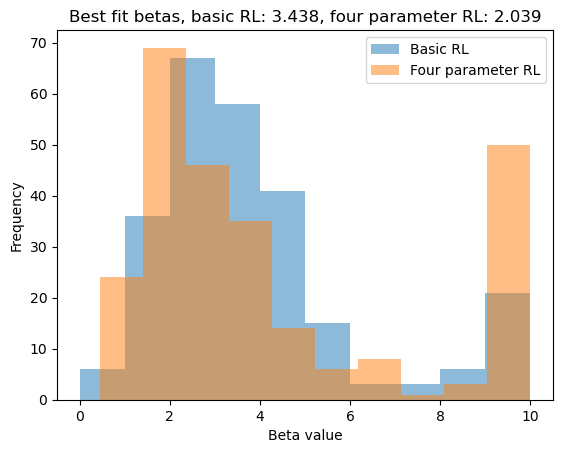

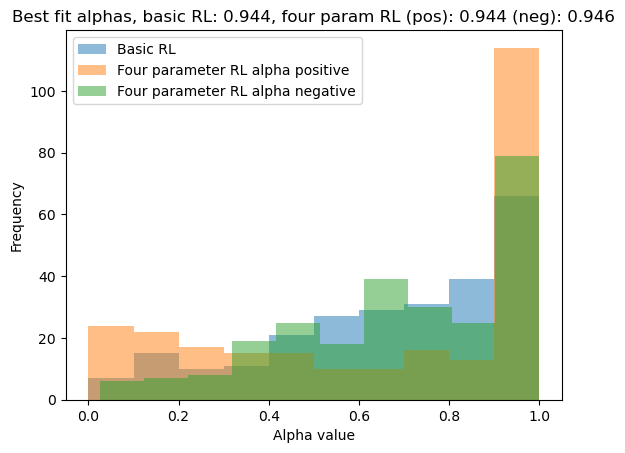

In [25]:
plt.figure()
plt.hist(basic_best_betas, alpha=0.5, label='Basic RL')
plt.hist(four_best_betas, alpha=0.5, label='Four parameter RL')
plt.xlabel('Beta value')
plt.ylabel('Frequency')
plt.title(f'Best fit betas, basic RL: {basic_beta_mode}, four parameter RL: {four_beta_mode}')
plt.legend()
# plt.savefig('figures/parameter_fitting_betas.png')

plt.figure()
plt.hist(basic_best_alphas, alpha=0.5, label='Basic RL')
plt.hist(four_best_alphapos, alpha=0.5, label='Four parameter RL alpha positive')
plt.hist(four_best_alphaneg, alpha=0.5, label='Four parameter RL alpha negative')
plt.xlabel('Alpha value')
plt.ylabel('Frequency')
plt.title(f'Best fit alphas, basic RL: {basic_alpha_mode}, four param RL (pos): {basic_alphapos_mode} (neg): {basic_alphaneg_mode}')
plt.legend()
# plt.savefig('figures/parameter_fitting_alphas.png')

# TODO: get mode


AIC basic: 25, four-param: 231
BIC basic: 82, four-param: 174


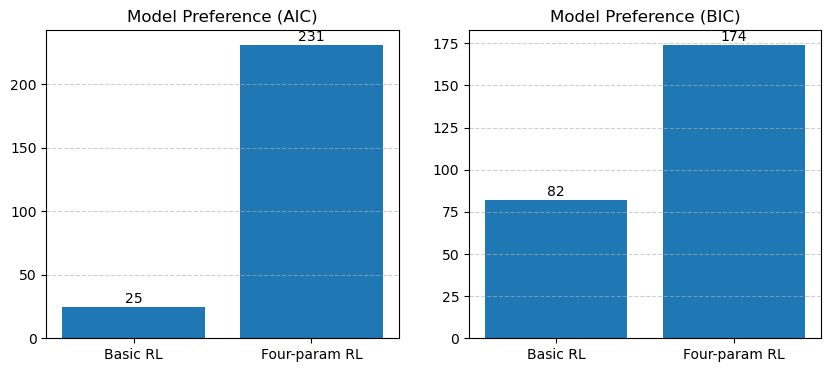

In [26]:
# get winning aic/bic moddels
aic_winner = np.argmin(AICs, axis=0)
# print(np.sum(aic_winner == 0) + np.sum(aic_winner == 1))  
bic_winner = np.argmin(BICs, axis=0)
# print(np.sum(bic_winner == 0) + np.sum(bic_winner == 1))  

# print(AICs[0])
# print(aic_winner[0])
# print(aic_winner[1])

print(f"AIC basic: {np.sum(aic_winner==0)}, four-param: {np.sum(aic_winner==1)}")
print(f"BIC basic: {np.sum(bic_winner==0)}, four-param: {np.sum(bic_winner==1)}")

labels = ['Basic RL', 'Four-param RL']
aic_counts = [np.sum(aic_winner==0), np.sum(aic_winner==1)]
bic_counts = [np.sum(bic_winner==0), np.sum(bic_winner==1)]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# plotting
# AIC
bars_aic = axes[0].bar(labels, aic_counts)
axes[0].set_title('Model Preference (AIC)')
axes[0].set_ylabel('')
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars_aic:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{int(bar.get_height())}', ha='center', va='bottom')

# BIC
bars_bic = axes[1].bar(labels, bic_counts)
axes[1].set_title('Model Preference (BIC)')
axes[1].set_ylabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars_bic:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{int(bar.get_height())}', ha='center', va='bottom')

# plt.savefig('figures/model_comparison_aic_bic.png')

## Model validation

In [27]:
# function that takes an array of participant data and calculates p correct for the trial
# individual participant data is structured as np.array([a, r, correct_box, trial, switch_trial, block])

# function that takes an array of participant data 
# and calculates the average percent correct across participants
# for 13 trials around a certain block.
def get_avg_pcorr(participant_data, block):
    # initialize an array of the avg pcorr for trials -4 to 9
    avg_pcorr = np.zeros(13, dtype=float)

    n_participants = 0
    # iterate over participant data
    for data in participant_data: 
        # extract the first 9 trials for that block as well as 4 trials before the start of the block
        block_trials = np.where(data[:, 5] == block)[0]
        if len(block_trials) == 0:
            # print(f"No trials found for block in participant {n_participants}")
            continue

        block_start = block_trials[0]
        block_nine_trials = data[block_trials[:9]]
        pre_block_trials = data[max(0, block_start - 4):block_start]
        
        trials = np.vstack((pre_block_trials, block_nine_trials)) # trials -4 to 9
        # check that there are 13 trials
        if trials.shape[0] < 13:
            # print(f"There are not enough trials in participant {n_participants}'s data")
            continue
        
        rewards = trials[:, 1]   # get rewards for trials -4 to 8

        # print("rewards:", rewards)

        # for the first participant, avg_pcorr = rewards
        if n_participants == 0:
            avg_pcorr = rewards
        # if the avg pcorr array is not empty
        else: 
            # calculate the mean of the current avg in the pcorr array with the new reward (ie. curr*r/2)
            for i, r in enumerate(rewards):
                avg_pcorr[i] = (avg_pcorr[i]+r)
        
        # print("avg_pcorr for trial:", avg_pcorr)
        n_participants+=1

    avg_pcorr = avg_pcorr.astype(float)
    for i in range(len(avg_pcorr)):
        avg_pcorr[i] = avg_pcorr[i]/n_participants

    # print("n_participants:", n_participants)
    # print("avg_pcorr", avg_pcorr)    
    return avg_pcorr

[1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


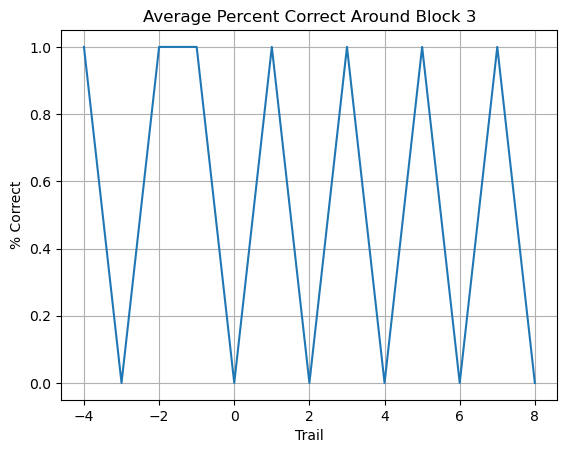

In [28]:
# Compare the simulated data of the basic and four parameter model to
# the empirical data. X-axis = blocks, Y-axis = p(correct) for that block

# for one simulation/participant
# simulate data and plot basic RL model
beta = np.random.uniform(1, 10)
alpha = np.random.uniform(0, 1)
RL_true_params = [beta, alpha]
nblocks = 7 # standardize number of blocks
basicData, basicQs = basic_RL(RL_true_params, nblocks)


block = 3
avg_pcorr = get_avg_pcorr([basic_Data], block)
print(avg_pcorr)

x = np.arange(-4, 9)

plt.plot(x, avg_pcorr)
plt.xlabel("Trail")
plt.ylabel("% Correct")
plt.title(f"Average Percent Correct Around Block {block}")
plt.grid(True)

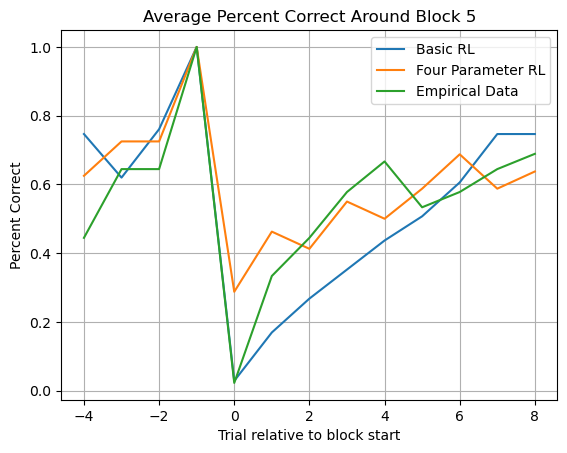

In [29]:
# simulate basic rl data 
n_participants = 100
nblocks = 7
block_list = list(range(1, nblocks + 1))  
basic_data_list = []
for p in range(n_participants):
    beta = np.random.uniform(1, 10)
    alpha = np.random.uniform(0, 1)
    RL_true_params = [beta, alpha]
    basic_data, Qs = basic_RL(RL_true_params, nblocks)
    basic_data_list.append(basic_data)

# # simulate four param rl data
fourparam_data_list = []
for p in range(n_participants):
    beta = np.random.uniform(1, 10)
    alphapos = np.random.uniform(0, 1)
    alphaneg = np.random.uniform(0, 1)
    persistence = np.random.uniform(0, 1)
    four_param_trueparams = [beta, alphapos, alphaneg, persistence]
    four_param_data, four_param_Qs = four_param_RL(four_param_trueparams, nblocks) 
    fourparam_data_list.append(four_param_data)

# get empiral data
empirical_data_list = []
for f in glob.glob("smaller_sample/*.csv"):
    empirical_data = format_data_for_model(f)
    if empirical_data is not None:
        empirical_data_list.append(empirical_data)

block = 5
basic_avg_pcorr = get_avg_pcorr(basic_data_list, block)
fourparam_avg_pcorr = get_avg_pcorr(fourparam_data_list, block)
empirical_avg_pcorr = get_avg_pcorr(empirical_data_list, block)

x = np.arange(-4, 9)

plt.plot(x, basic_avg_pcorr, label='Basic RL')
plt.plot(x, fourparam_avg_pcorr, label='Four Parameter RL')
plt.plot(x, empirical_avg_pcorr, label='Empirical Data')
plt.xlabel("Trial relative to block start")
plt.ylabel("Percent Correct")
plt.title(f"Average Percent Correct Around Block {block}")
plt.grid(True)
plt.legend()  
# plt.savefig('figures/model_validation.png')

## Analysis with Demographic Data

In [30]:
# patient id (pid) in per participant data is mapped to ID in demograohics.csv
# Eckstein et al. bin into equal-sized age groups
# 8-10, 10-13, 13-15, 15-17, 18-24, 25-30
# overall accuracy vs. age
# fitted parameter values vs. age

# function to parse demographic data and bin participant data
def get_age_bins(participants_path, demographics_path):
    # initialize arrays for each age bin
    age_bins = [
        ('8-10', 8, 10),
        ('10-13', 10, 13),
        ('13-15', 13, 15),
        ('15-17', 15, 17),
        ('18-24', 18, 24),
        ('25-30', 25, 31)
    ]
    binned_data = {age_bin: [] for (age_bin, min, max) in age_bins}

    # read in demographic data
    demographics = pd.read_csv(demographics_path)
    ids = demographics.iloc[:,0].astype(str) # find ID in demographics.csv file col 1
    ages = demographics.iloc[:,9]  # extract age from demographics.csv (precise years col 10) as a whole number
    id_age_map = dict(zip(ids, ages))  # map id to age
    
    # iterate over each participant's .csv file
    for file in glob.glob(os.path.join(participants_path, "*.csv")):
        participant_data = pd.read_csv(file)
        
        # get sID in participants .csv file col 5
        sID = str(participant_data.iloc[0, 4])
        
        # compare sID and ID and add participant to the corresponding bin
        if sID in id_age_map:
            p_age = float(id_age_map[sID])
            for age_bin, min, max in age_bins:
                    if min <= p_age < max:
                        binned_data[age_bin].append(file)
                        break
        else:
            print(f"Could not find {sID} in demographics file.")

    return binned_data

# participant avg_pcorr
def participant_avg_pcorr(participant_data):
    rewards = participant_data[:,1]
    return np.sum(rewards)/participant_data.shape[0]

# function to get overall accuracy vs. age as a scatter plot
def accuracy_vs_age(binned_data):    
    age_bins = list(binned_data.keys())
    accuracies = {}
    
    # for each age bin
    for bin in age_bins:
        participant_list = binned_data[bin]
        p_accuracies = []
        # for each participant, need to calculate avg_pcorr for age
        for p in participant_list:
            p_data = format_data_for_model(p)
            p_avg = participant_avg_pcorr(p_data)
            p_accuracies.append(p_avg)
            
        accuracies[bin] = np.mean(p_accuracies)
    
    return accuracies

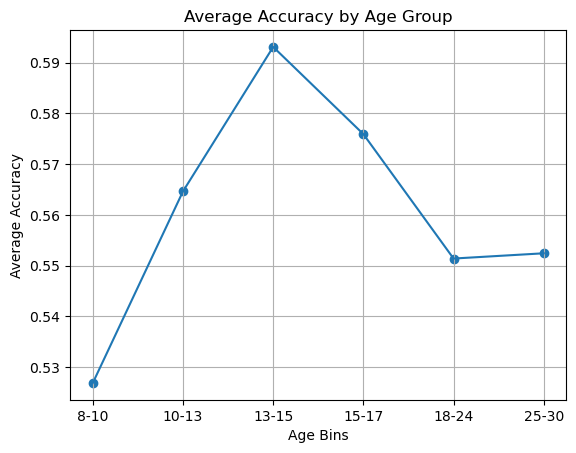

In [31]:
#  empirical data
binned_data = get_age_bins('participant_data', 'demographics.csv') 
accuracies_dict = accuracy_vs_age(binned_data)
age_bins = list(accuracies_dict.keys())
accuracies = [accuracies_dict[bin] for bin in age_bins]

plt.figure()
plt.scatter(age_bins, accuracies)
plt.plot(age_bins, accuracies, linestyle='-')
plt.xlabel("Age Bins")
plt.ylabel("Average Accuracy")
plt.title(f"Average Accuracy by Age Group")
plt.grid()
# plt.savefig('figures/demo_avg_accuracy.png')

In [32]:
# a function to map the best params to bins, given code that has already been implemented.

# map files in participant data to an index
file_i_map = {os.path.basename(f): i for i, f in enumerate(sorted(glob.glob(os.path.join("participant_data", "*.csv"))))}

# given the binned participants and the best fit parameters,
# map the binned participants to their best fir parameter
def bin_best_param_map(binned_data, best_fit_params):
    bin_params = {} # initialize a bin-best params dict

    # for each bin in the binned data
    for bin, file_list in binned_data.items():
        params = [] # initialize params

        # for each file in the binned data
        for f in file_list:
            # get the filename with no extension
            f_base = os.path.basename(f)
            if f_base in file_i_map:
                i = file_i_map[f_base]    # get the index of the file
                params.append(best_fit_params[i])   # get the params at that index

        bin_params[bin] = np.mean(params)   # calculate average of best params

    return bin_params

# get binned best params
basic_beta_by_bin = bin_best_param_map(binned_data, basic_best_betas)
# print(basic_beta_by_bin)
basic_alpha_by_bin = bin_best_param_map(binned_data, basic_best_alphas)

four_beta_by_bin = bin_best_param_map(binned_data, four_best_betas)
four_alphapos_by_bin = bin_best_param_map(binned_data, four_best_alphapos)
four_alphaneg_by_bin = bin_best_param_map(binned_data, four_best_alphaneg)
four_p_by_bin = bin_best_param_map(binned_data, four_best_p)

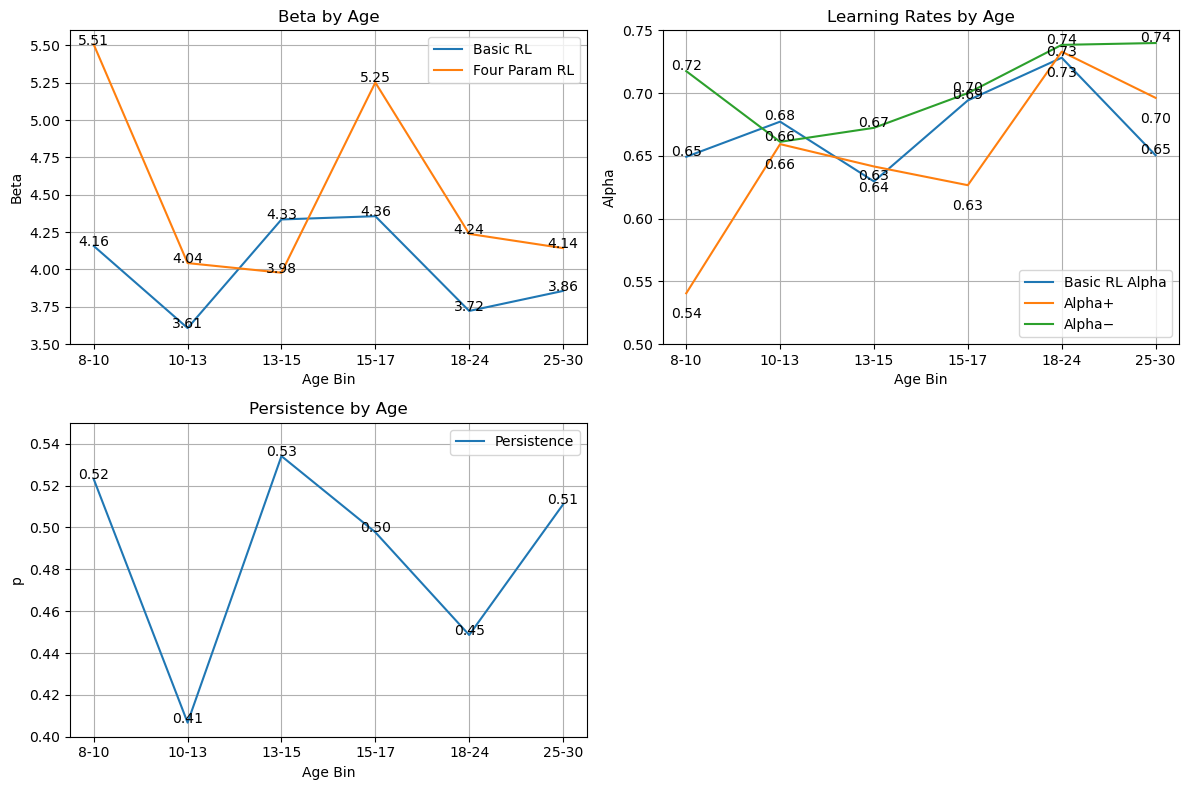

In [33]:
# plotting
# Eckstein et al. plot the fitted parameters with unique y-axis values

age_bins = ['8-10', '10-13', '13-15', '15-17', '18-24', '25-30']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# beta
axs[0, 0].plot(age_bins, [basic_beta_by_bin[b] for b in age_bins], label='Basic RL')
axs[0, 0].plot(age_bins, [four_beta_by_bin[b] for b in age_bins], label='Four Param RL')
axs[0, 0].set_title('Beta by Age')
axs[0, 0].set_ylim(3.5, 5.6)
axs[0, 0].set_ylabel('Beta')
axs[0, 0].legend()

# alpha(s)
axs[0, 1].plot(age_bins, [basic_alpha_by_bin[b] for b in age_bins], label='Basic RL Alpha')
axs[0, 1].plot(age_bins, [four_alphapos_by_bin[b] for b in age_bins], label='Alpha+')
axs[0, 1].plot(age_bins, [four_alphaneg_by_bin[b] for b in age_bins], label='Alpha−')
axs[0, 1].set_title('Learning Rates by Age')
axs[0, 1].set_ylim(0.5, 0.75)
axs[0, 1].set_ylabel('Alpha')
axs[0, 1].legend()

# persistence
axs[1, 0].plot(age_bins, [four_p_by_bin[b] for b in age_bins], label='Persistence')
axs[1, 0].set_title('Persistence by Age')
axs[1, 0].set_ylim(0.4, 0.55)
axs[1, 0].set_ylabel('p')
axs[1, 0].legend()

axs[1, 1].axis('off')

for i, age_bin in enumerate(age_bins):
    axs[0, 0].text(age_bin, [basic_beta_by_bin[b] for b in age_bins][i], f"{[basic_beta_by_bin[b] for b in age_bins][i]:.2f}", ha='center')
    axs[0, 0].text(age_bin, [four_beta_by_bin[b] for b in age_bins][i], f"{[four_beta_by_bin[b] for b in age_bins][i]:.2f}", ha='center')
    axs[0, 1].text(age_bin, [basic_alpha_by_bin[b] for b in age_bins][i] + 0.001, f"{[basic_alpha_by_bin[b] for b in age_bins][i]:.2f}", ha='center')
    axs[0, 1].text(age_bin, [four_alphapos_by_bin[b] for b in age_bins][i] - 0.02, f"{[four_alphapos_by_bin[b] for b in age_bins][i]:.2f}", ha='center')
    axs[0, 1].text(age_bin, [four_alphaneg_by_bin[b] for b in age_bins][i] + 0.001, f"{[four_alphaneg_by_bin[b] for b in age_bins][i]:.2f}", ha='center')
    axs[1, 0].text(age_bin, [four_p_by_bin[b] for b in age_bins][i], f"{[four_p_by_bin[b] for b in age_bins][i]:.2f}", ha='center')

for ax in axs.flat:
    ax.set_xlabel('Age Bin')
    ax.grid(True)

plt.tight_layout()
# plt.savefig('figures/demo_fitted_parameters_by_age.png')
plt.show()